# Auswertung XGB-Modell

#### Importe

In [1]:
import xgboost as xgb
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import ConnectionPatch
from pathlib import Path
from sklearn.metrics import r2_score as r2
from sklearn.metrics import max_error
import timeit

#### Plot Stylesheet

In [2]:
plt.style.use(['seaborn-v0_8-paper', Path.cwd().parent / 'plotstyle' / 'paper.mplstyle'])
cm = 1/2.54

#### Laden des Netzes

In [3]:
xgb_model = xgb.Booster()
xgb_model.load_model(Path.cwd().parent /'data' / 'models' / 'xgb_011_030.json')
#xgb_model.eval()

#### Einblick ins Netzwerk

In [4]:
#print(list(net.named_parameters()))

### Verläufe mit konstant gehaltenen Parametern

#### Laden und Preprocessing der GGW-Daten

In [5]:
# Daten Extrapolation
eq_data_file_T = Path.cwd().parent / 'data' / 'eq_dataset_T_var.npz' #Import der GGW Daten
data_T = np.load(eq_data_file_T)

# Bei Speicherung wurden Daten als T, p, x_0 und x gespeichert
# Inputs T, p, x_0[H2,N2,NH3]
# Output x[NH3]
T = np.array(data_T['T'])
p = np.array(data_T['p'])
x_0 = np.array(data_T['x_0'])
x = np.array(data_T['x'])

X = np.stack((T, p , np.full_like(T, x_0[0]),np.full_like(T, x_0[1]),np.full_like(T, x_0[2])),axis=1)
y = x # [H2, NH3], dritter Stoffmengenanteil ergibt sich den anderen

#### Vorhersage der GGW-Daten

In [6]:
dtest = xgb.DMatrix(X, y)
pred = xgb_model.predict(dtest)


#### Auswertung des Verlaufs mit konstantem Druck und konstanten x_0 - Parity Plot

Training Dataset: R^2(NH3) = 0.9858043651141141
Max Error Training: |x_NH3 - x_NH3,pred| = 0.015146871538234602


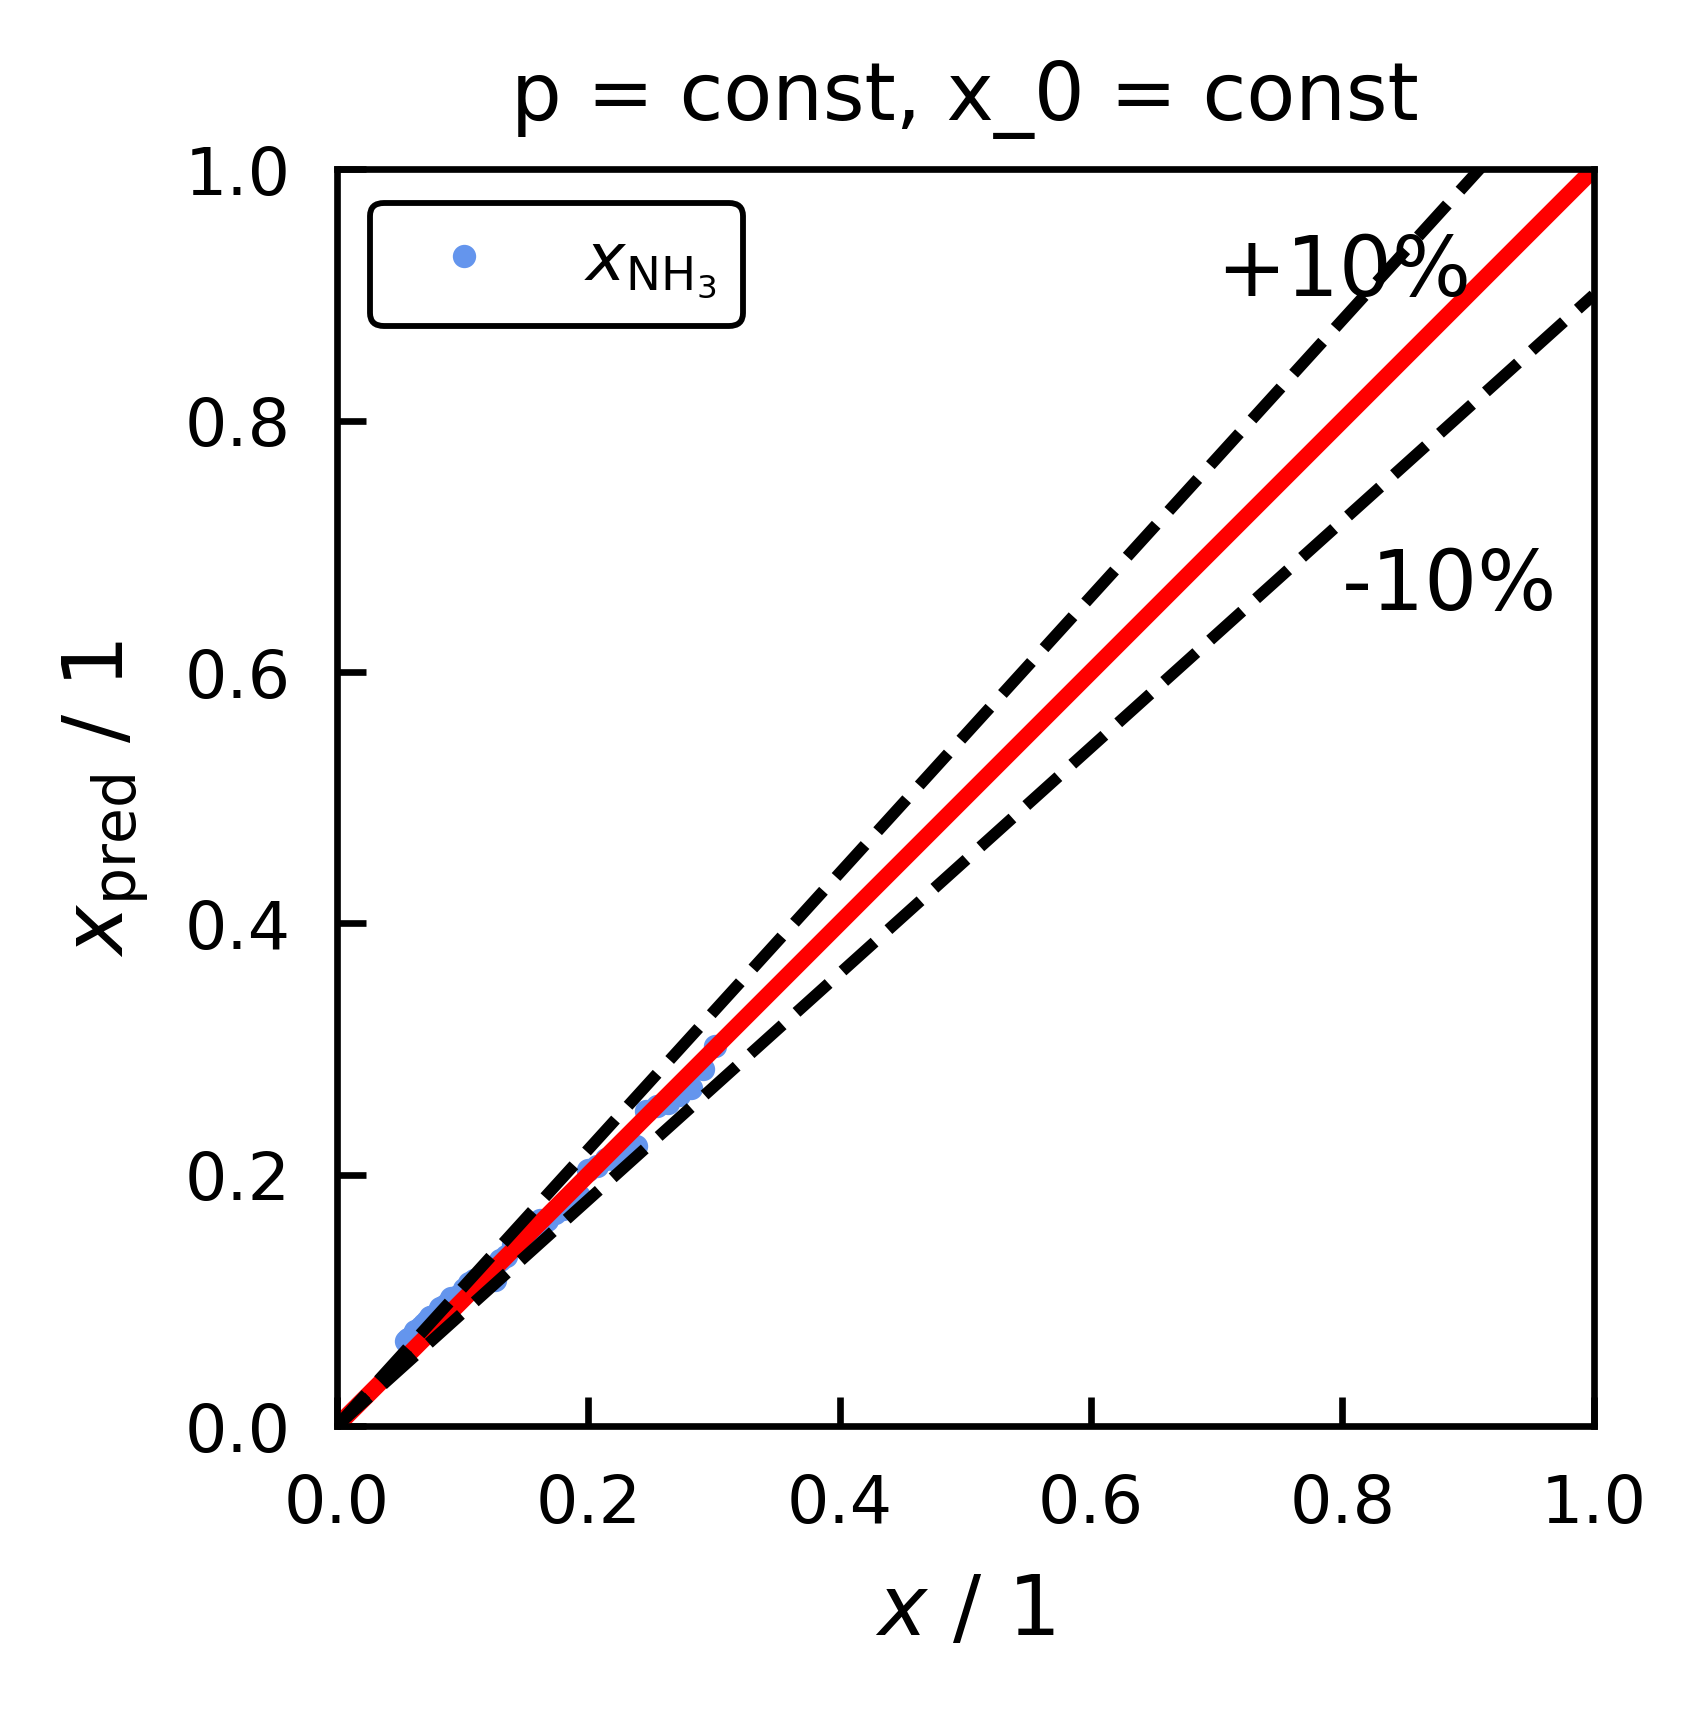

In [7]:
x_NH3_real = y
x_NH3_pred = pred[:,1]

print('Training Dataset: R^2(NH3) =', r2(x_NH3_real,x_NH3_pred))
print('Max Error Training: |x_NH3 - x_NH3,pred| =', max_error(x_NH3_real, x_NH3_pred))

# Set the boundaries of X and Y values
bounds = (0,1)

fig,ax = plt.subplots(1, figsize =(7.5*cm,7.5*cm))

# # Reset the limits
# ax[0] = plt.gca()
ax.set_xlim(bounds)
ax.set_ylim(bounds)
# Ensure the aspect ratio is square
ax.set_aspect("equal", adjustable="box")

ax.plot(x_NH3_real, x_NH3_pred, '.', color ='cornflowerblue', label = '$x\mathregular{_{NH_3}}$')
ax.plot([0, 1], [0, 1], "r-",lw=2 ,transform=ax.transAxes)
ax.plot([bounds[0],bounds[1]], [bounds[0] * 1.1, bounds[1] * 1.1], "k--") # Error line
ax.plot([bounds[0],bounds[1]], [bounds[0] * 0.9, bounds[1] * 0.9], "k--") # Error line
ax.text(0.7, 0.9, '+10%')
ax.text(0.8, 0.65, '-10%')
ax.set(xlabel = '$x$ / 1', ylabel = '$x\mathregular{_{pred}}$ / 1')
ax.tick_params(direction = 'in') #, length = 20, width = 3)
ax.set_title('p = const, x_0 = const')
ax.legend()
#ax.legend(['$\\mathregular{R^2}$ = ', r2(xi_real,xi_pred)], markerscale=0)

#plt.legend()
#fig.suptitle("Parity Plot")
plt.tight_layout()
plt.show()

#### Auswertung Verlauf x_NH3 über T, p =const, x_0 = const

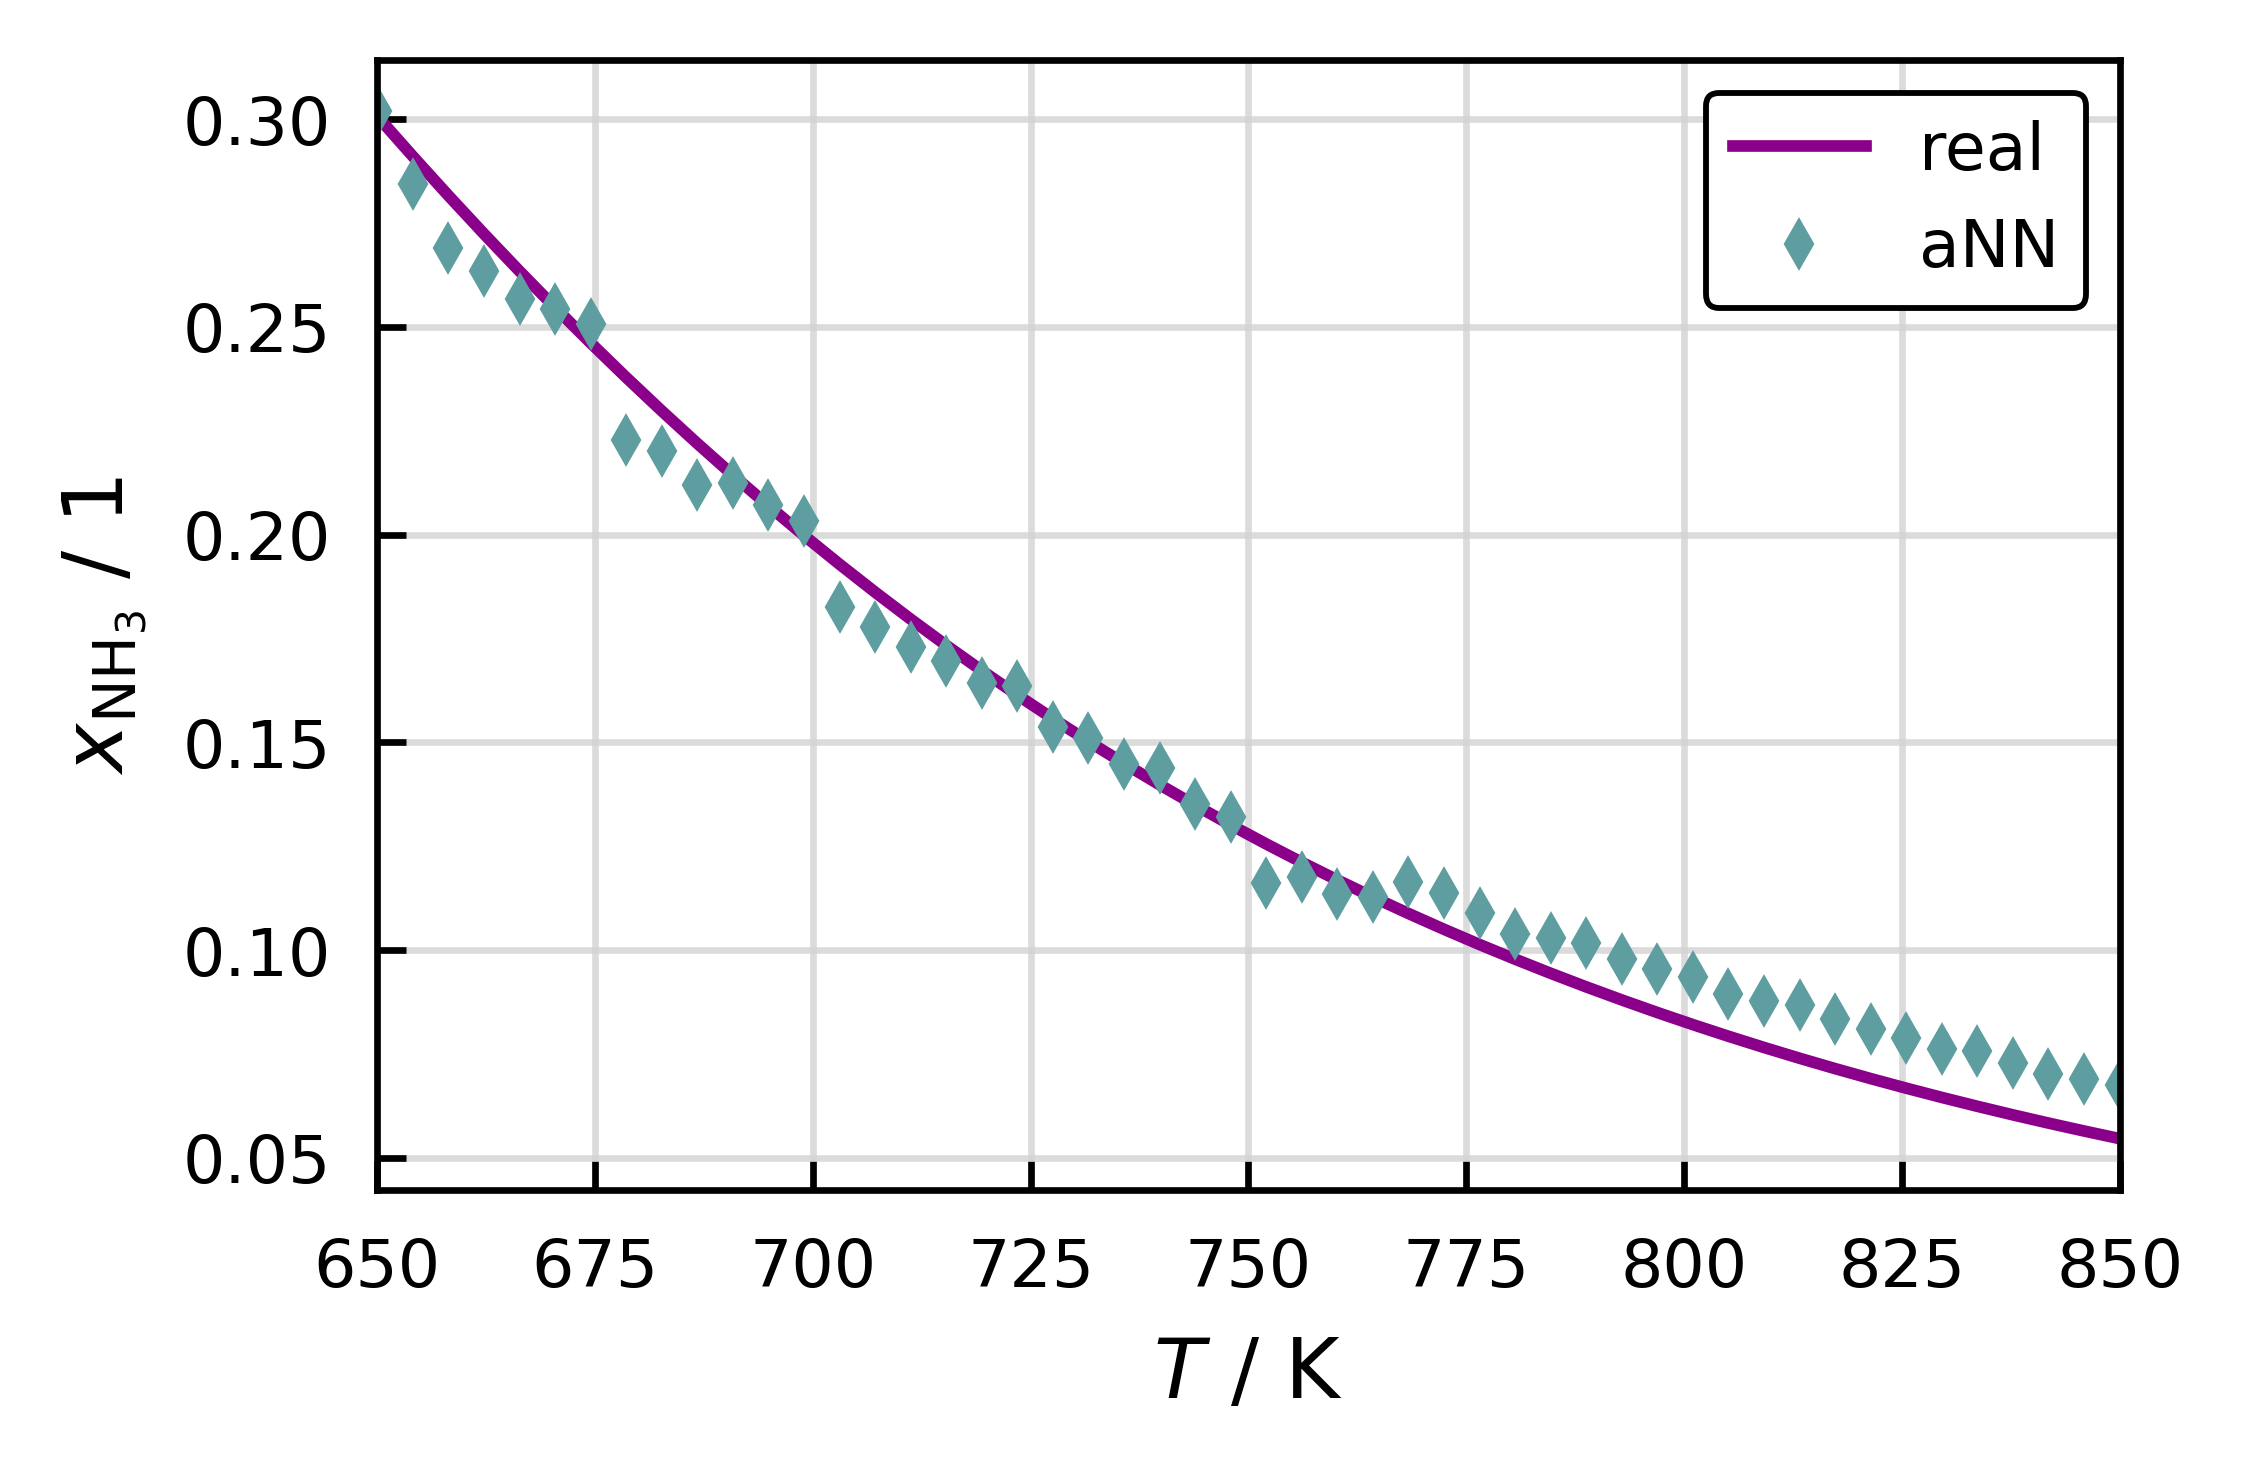

In [8]:
fig,ax = plt.subplots(figsize=(9.75*cm, 6.5*cm))

ax.plot(X[:,0], x_NH3_real, '-', label = 'real')
ax.plot(X[:,0], x_NH3_pred, 'd', markeredgewidth = 0.7, markersize = 3.5,label = 'aNN')
ax.set(xlabel = '$T$ / K', ylabel = '$x\mathregular{_{NH_3}}$ / 1')
ax.tick_params(direction = 'in') #, length = 20, width = 3)
#ax.set_title('p = const, x_0 = const')
ax.set(xlim=(650,850))
ax.legend()
ax.grid()
#ax.legend(['$\\mathregular{R^2}$ = ', r2(xi_real,xi_pred)], markerscale=0)

#plt.legend()
#fig.suptitle("Parity Plot")
plt.tight_layout()
plt.show()

In [9]:
#fig.savefig(Path.cwd().parent / 'plots/ann/TKA_SRA_PA_003_verlauf.png', bbox_inches = 'tight')

### Extrapolation

#### Laden und Preprocessing der GGW-Daten

In [10]:
# Daten Extrapolation
eq_data_file_extra = Path.cwd().parent / 'data' / 'eq_dataset_x_extra.npz' #Import der GGW Daten
extra_data = np.load(eq_data_file_extra)

# Bei Speicherung wurden Daten als T, p, x_0 und x gespeichert
# Inputs T, p, x_0[H2,N2,NH3]
# Output x[H2, NH3]
T = (extra_data['T'])
p = (extra_data['p'])
x_0 = (extra_data['x_0'])
x = (extra_data['x'])

X = np.stack((T, p ,x_0[:,0],x_0[:,1],x_0[:,2]),axis=1)
y = np.stack((x[:,0], x[:,2]), 1) # [H2, NH3], dritter Stoffmengenanteil ergibt sich den anderen

#### Vorhersage der GGW-Daten

In [11]:
#Vorhersage
dtest = xgb.DMatrix(X, y)
pred = xgb_model.predict(dtest)

#### Auswertung der Extrapolation - Parity Plot

Training Dataset: R^2(H2) = 0.6994656983459957 , R^2(NH3) = 0.2917592499648013
Max Error Training: |x_H2 - x_H2,pred| = 0.29682525466624216 , |x_NH3 - x_NH3,pred| = 0.3822768459182976


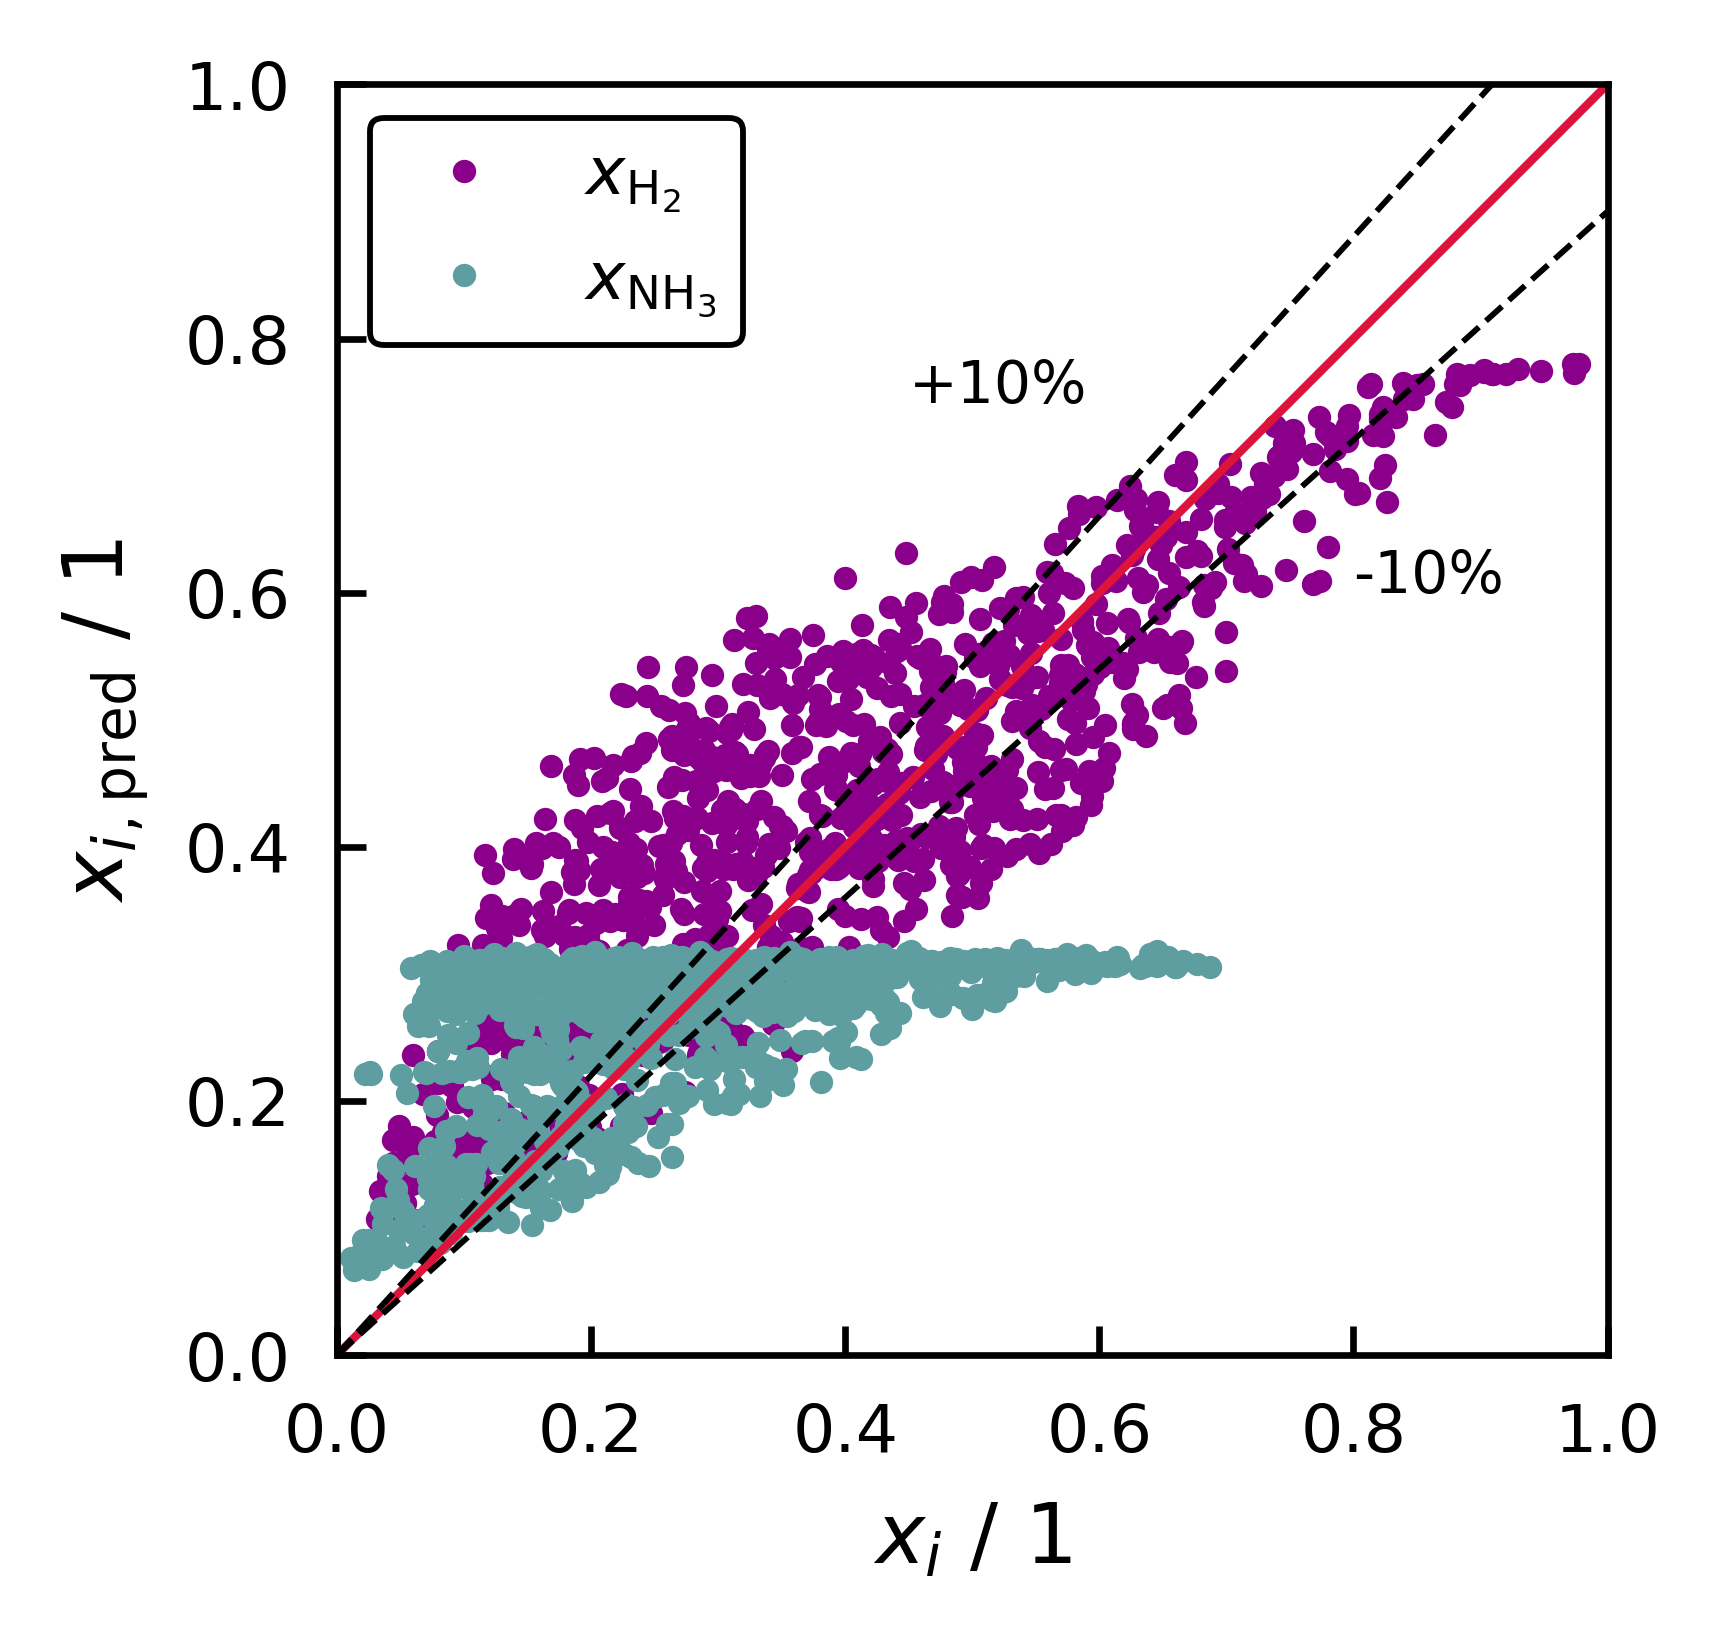

In [12]:
x_H2_real = y[:,0]
x_NH3_real = y[:,1]
x_H2_pred = pred[:,0] 
x_NH3_pred = pred[:,1]

print('Training Dataset: R^2(H2) =', r2(x_H2_real,x_H2_pred), ', R^2(NH3) =', r2(x_NH3_real,x_NH3_pred))
print('Max Error Training: |x_H2 - x_H2,pred| =', max_error(x_H2_real, x_H2_pred), ', |x_NH3 - x_NH3,pred| =', max_error(x_NH3_real, x_NH3_pred))

# find the boundaries of X and Y values
bounds = (0,1)

fig,ax = plt.subplots(1, figsize =(7.5*cm,7.5*cm))

# # Reset the limits
# ax[0] = plt.gca()
ax.set_xlim(bounds)
ax.set_ylim(bounds)
# Ensure the aspect ratio is square
ax.set_aspect("equal", adjustable="box")

ax.plot(x_H2_real, x_H2_pred, '.', label = '$x\mathregular{_{H_2}}$')
ax.plot(x_NH3_real, x_NH3_pred, '.', label = '$x\mathregular{_{NH_3}}$')
ax.plot([0, 1], [0, 1], "-", color = 'crimson',lw=1 ,transform=ax.transAxes)
ax.plot([bounds[0],bounds[1]], [bounds[0] * 1.1, bounds[1] * 1.1], "k--", lw=0.7) # Error line
ax.plot([bounds[0],bounds[1]], [bounds[0] * 0.9, bounds[1] * 0.9], "k--", lw=0.7) # Error line
ax.text(0.45, 0.75, '+10%', fontsize=7)
ax.text(0.8, 0.6, '-10%', fontsize=7)
ax.set(xlabel = '$x_i$ / 1', ylabel = '$x_i\mathregular{_{,pred}}$ / 1')
ax.tick_params(direction = 'in') #, length = 20, width = 3)
#ax.set_title('Extrapolation Data')
ax.legend()
#ax.legend(['$\\mathregular{R^2}$ = ', r2(xi_real,xi_pred)], markerscale=0)

#plt.legend()
#fig.suptitle("Parity Plot")
plt.tight_layout()
plt.show()

In [13]:
#fig.savefig(Path.cwd().parent / 'plots/ann/TKA_SRA_PA_004_parity_extra_1.png', bbox_inches = 'tight')

#### Debugging Hilfe

In [14]:
# print(X)
# print(y * std_out + mean_out)
# x_H2, x_NH3 = (net(X).detach().numpy()).T
# print(x_H2 * std_out[0].numpy() + mean_out[0].numpy(), ', ', x_NH3 * std_out[1].numpy() + mean_out[1].numpy())

### Wie weit extrapolierbar?

#### Laden und Preprocessing der Daten; p = const; x_0 = const

In [15]:
# Daten Extrapolation
eq_data_file_T_var_extra_haber = Path.cwd().parent / 'data' / 'eq_dataset_T_var_extra_haber.npz' #Import der GGW Daten
data_T_extra_haber = np.load(eq_data_file_T_var_extra_haber)

# Bei Speicherung wurden Daten als T, p, x_0 und x gespeichert
# Inputs T, p, x_0[H2,N2,NH3]
# Output x[NH3]
T = (data_T_extra_haber['T'])
p = (data_T_extra_haber['p'])
x_0 = (data_T_extra_haber['x_0'])
x = (data_T_extra_haber['x'])

X_1 = np.stack((T, np.full_like(T, p[0]) , np.full_like(T, x_0[0]),np.full_like(T, x_0[1]),np.full_like(T, x_0[2])),1)
y_1 = x[:,0] # [H2, NH3], dritter Stoffmengenanteil ergibt sich den anderen
X_2 = np.stack((T, np.full_like(T, p[1]) , np.full_like(T, x_0[0]),np.full_like(T, x_0[1]),np.full_like(T, x_0[2])),1)
y_2 = x[:,1] # [H2, NH3], dritter Stoffmengenanteil ergibt sich den anderen
X_3 = np.stack((T, np.full_like(T, p[2]) , np.full_like(T, x_0[0]),np.full_like(T, x_0[1]),np.full_like(T, x_0[2])),1)
y_3 = x[:,2] # [H2, NH3], dritter Stoffmengenanteil ergibt sich den anderen
X_4 = np.stack((T, np.full_like(T, p[3]) , np.full_like(T, x_0[0]),np.full_like(T, x_0[1]),np.full_like(T, x_0[2])),1)
y_4 = x[:,3] # [H2, NH3], dritter Stoffmengenanteil ergibt sich den anderen
X_5 = np.stack((T, np.full_like(T, p[4]) , np.full_like(T, x_0[0]),np.full_like(T, x_0[1]),np.full_like(T, x_0[2])),1)
y_5 = x[:,4] # [H2, NH3], dritter Stoffmengenanteil ergibt sich den anderen
# print(X)

#### Vorhersage der GGW Daten

In [16]:
dtest_1 = xgb.DMatrix(X_1, y_1)
dtest_2 = xgb.DMatrix(X_2, y_2)
dtest_3 = xgb.DMatrix(X_3, y_3)
dtest_4 = xgb.DMatrix(X_4, y_4)
dtest_5 = xgb.DMatrix(X_5, y_5)

pred_1 = xgb_model.predict(dtest_1)
pred_2 = xgb_model.predict(dtest_2)
pred_3 = xgb_model.predict(dtest_3)
pred_4 = xgb_model.predict(dtest_4)
pred_5 = xgb_model.predict(dtest_5)

#### Auswertung Verlauf x_NH3 über T, p =const, x_0 = const, Inter- und Extrapolation

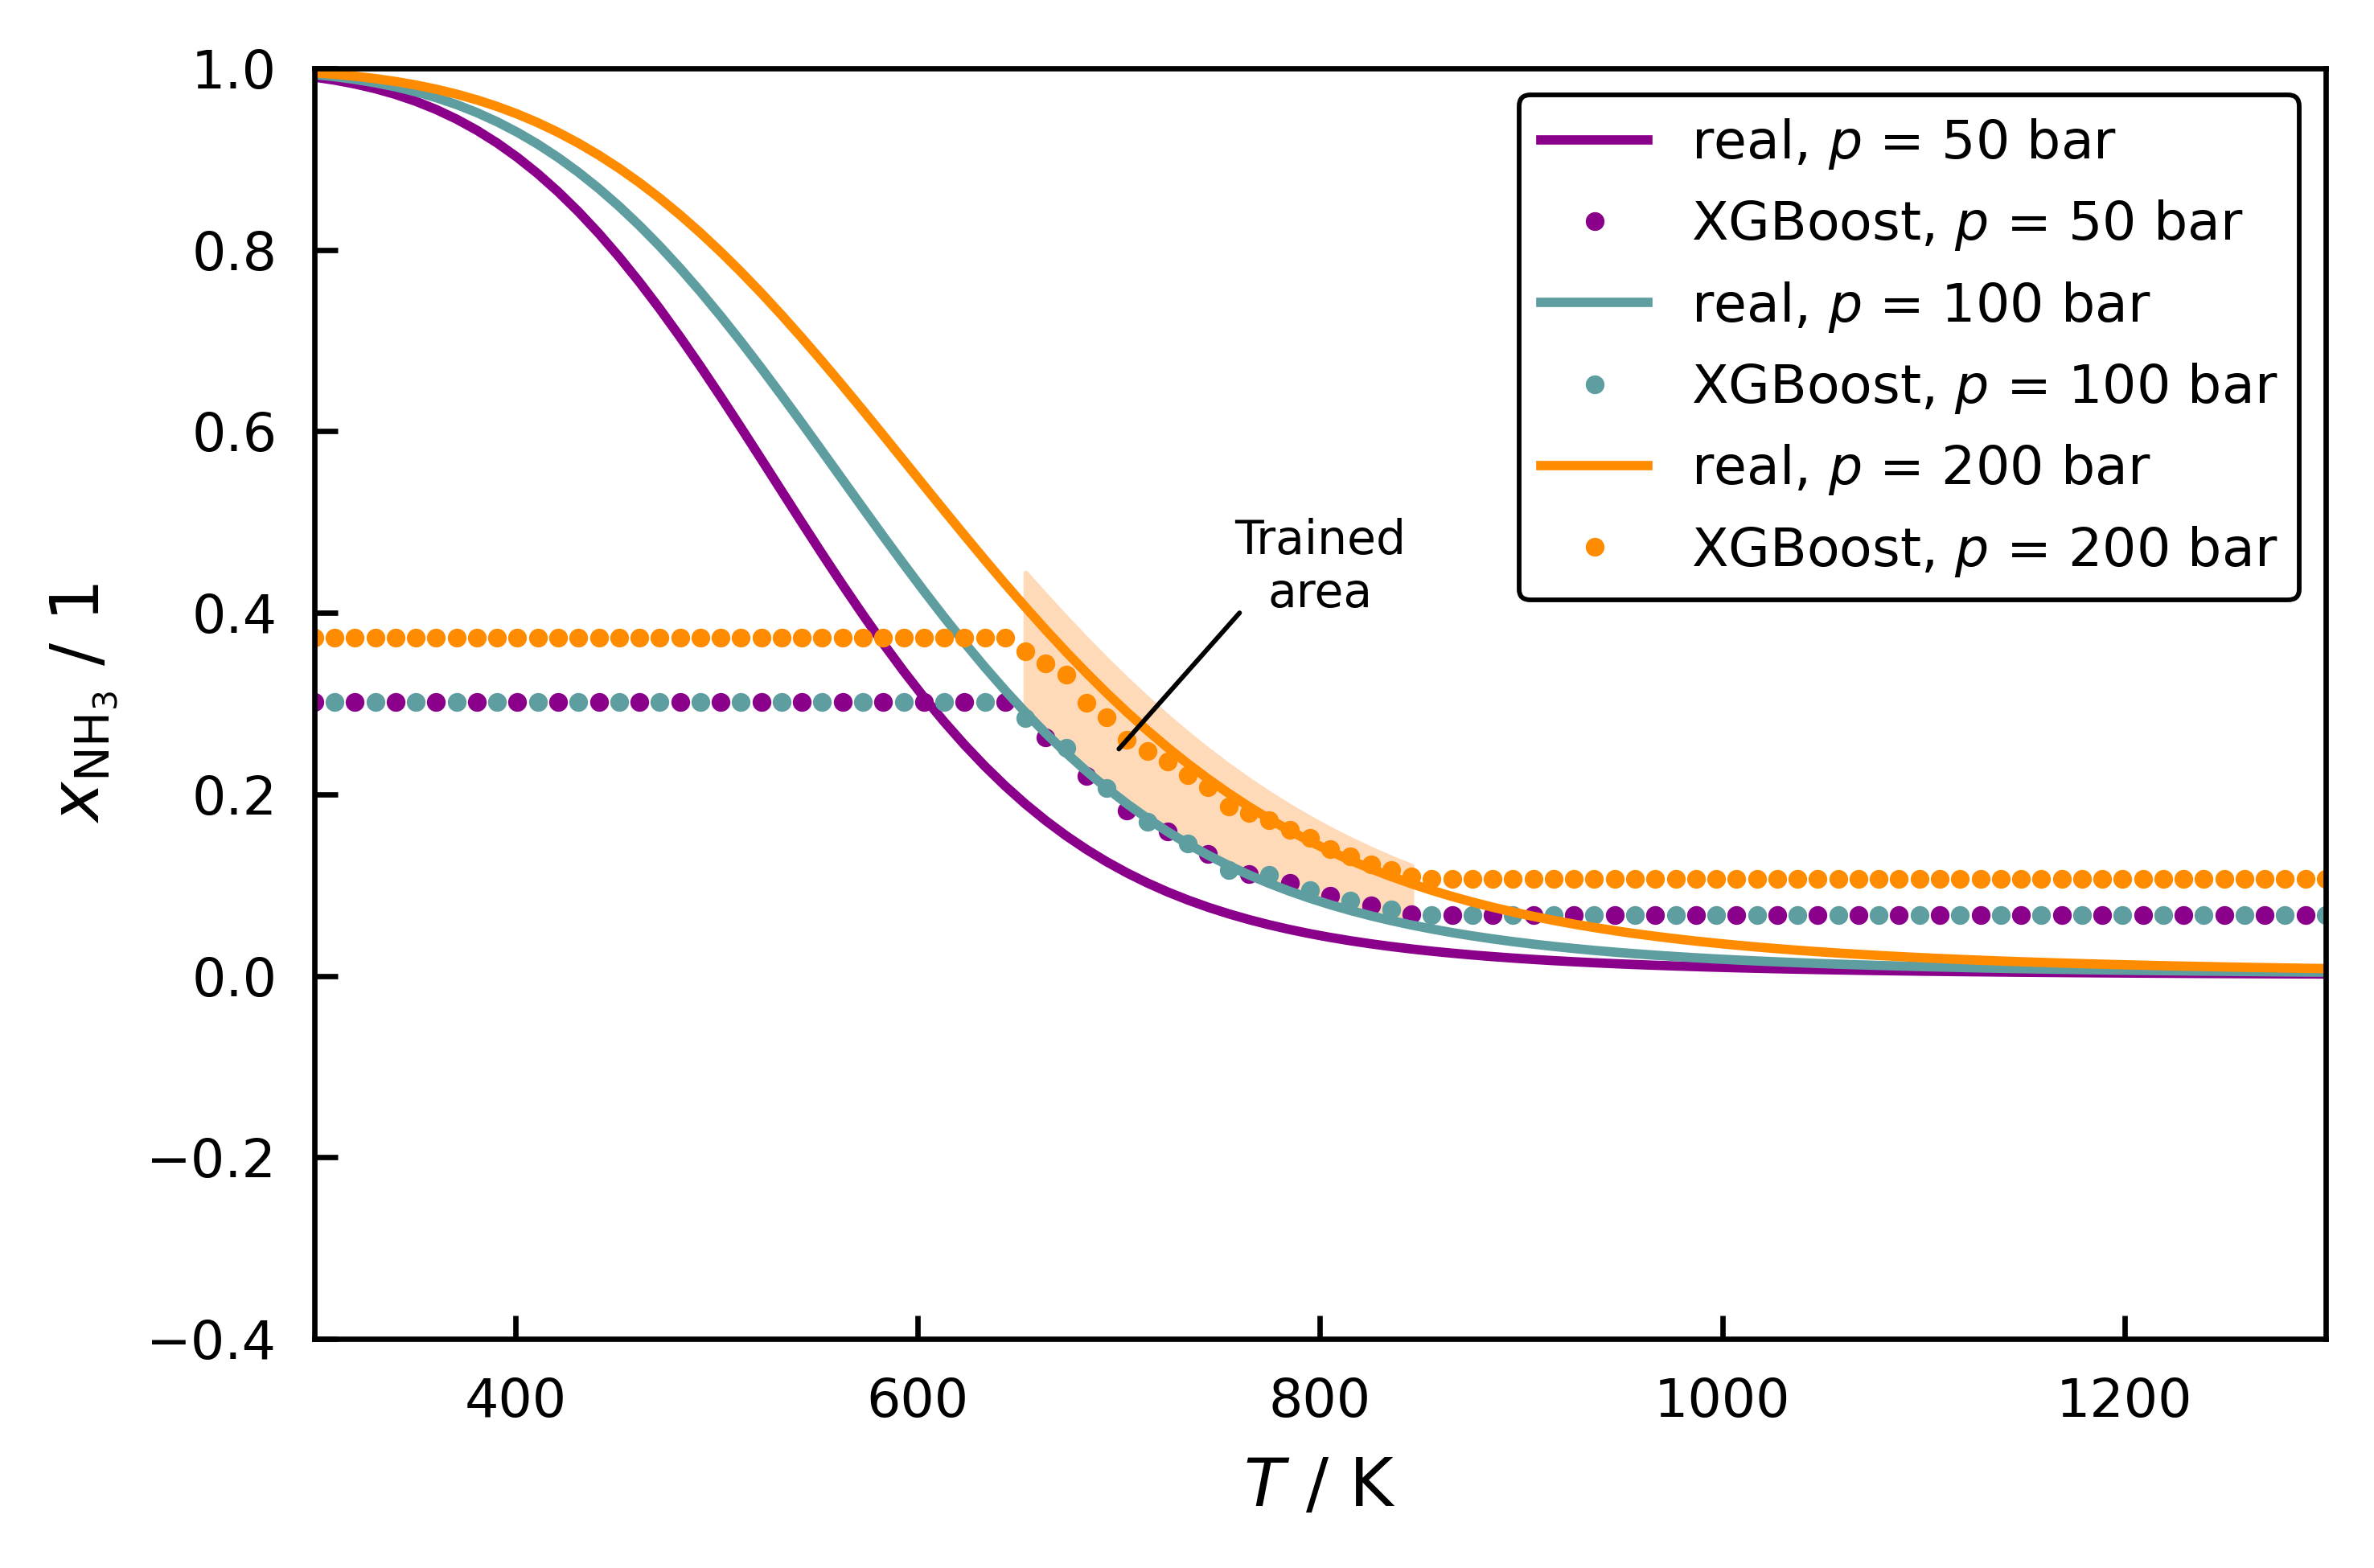

In [17]:
x_NH3_real_1 = y_1
x_NH3_pred_1 = pred_1[:,1]
x_NH3_real_2 = y_2
x_NH3_pred_2 = pred_2[:,1]
x_NH3_real_3 = y_3
x_NH3_pred_3 = pred_3[:,1]
x_NH3_real_4 = y_4
x_NH3_pred_4 = pred_4[:,1]
x_NH3_real_5 = y_5
x_NH3_pred_5 = pred_5[:,1]


#print(x_NH3_pred_1)
fig,ax = plt.subplots()

ax.plot(X_1[:,0], x_NH3_real_1, '-', color ='darkmagenta', label = 'real, $p$ = 50 bar')
ax.plot(X_1[:,0][::2], x_NH3_pred_1[::2], '.', color ='darkmagenta', label = 'XGBoost, $p$ = 50 bar')
ax.plot(X_2[:,0], x_NH3_real_2, '-', color ='cadetblue', label = 'real, $p$ = 100 bar')
ax.plot(X_2[1:,0][::2], x_NH3_pred_2[1:][::2], '.', color ='cadetblue', label = 'XGBoost, $p$ = 100 bar')
ax.plot(X_3[:,0], x_NH3_real_3, '-', color ='darkorange', label = 'real, $p$ = 200 bar')
ax.plot(X_3[:,0], x_NH3_pred_3, '.', color ='darkorange', label = 'XGBoost, $p$ = 200 bar')
# ax.plot(X_4[:,0], x_NH3_real_4, '-', color ='crimson', label = 'real, p = 250 bar')
# ax.plot(X_4[:,0], x_NH3_pred_4, '.', color ='crimson', label = 'aNN, p = 250 bar')
# ax.plot(X_5[:,0], x_NH3_real_5, '-', color ='yellowgreen', label = 'real, p = 300 bar')
# ax.plot(X_5[:,0], x_NH3_pred_5, '.', color ='yellowgreen', label = 'aNN, p = 300 bar')

# ax.axvline(x=650, color='black', linestyle='dashed')
# ax.axvline(x=850, color='black', linestyle='dashed')

#fill in training arreas
X_help = X_2
index_650 = np.where(X_help[:,0] >= 650)[0][0]
index_850 = np.where(X_help[:,0] >= 850)[0][0]

# print(index_500)
# print(X_2[index_500:index_650,0])
fill = ax.fill_between(X_2[index_650:index_850, 0],x_NH3_real_2[index_650:index_850], x_NH3_real_4[index_650:index_850], color = 'peachpuff', alpha = 1, zorder=1)#, label = 'Haber-Bosch')#,alpha = 0.6)

#Beschriftung Fläche
(x0, y0), (x1, y1) = fill.get_paths()[0].get_extents().get_points()
ax.text(800, (y0 + y1) / 2 + 0.2, "Trained\narea", ha='center', va='center', fontsize=7, color='black', zorder=100)
con = ConnectionPatch(xyA=(700, 0.25), coordsA=ax.transData,
                      xyB=(760,0.4), coordsB=ax.transData, lw = 0.7, zorder=100)
ax.add_artist(con)
ax.set(xlabel = '$T$ / K', ylabel = '$x\mathregular{_{NH_3}}$ / 1')
ax.set(xlim=(300,1300),ylim=(-0.4,1))
ax.tick_params(direction = 'in') #, length = 20, width = 3)
#ax.set_title('p = const, x_0 = const')
ax.legend()
#ax.legend(['$\\mathregular{R^2}$ = ', r2(xi_real,xi_pred)], markerscale=0)

#plt.legend()
#fig.suptitle("Parity Plot")
plt.tight_layout()
plt.show()

In [18]:
#fig.savefig(Path.cwd().parent / 'plots/ann/TKA_SRA_PA_005_verlauf_extra_1.png', bbox_inches = 'tight')

#### Parity Plot

663.6363636363636
845.4545454545454


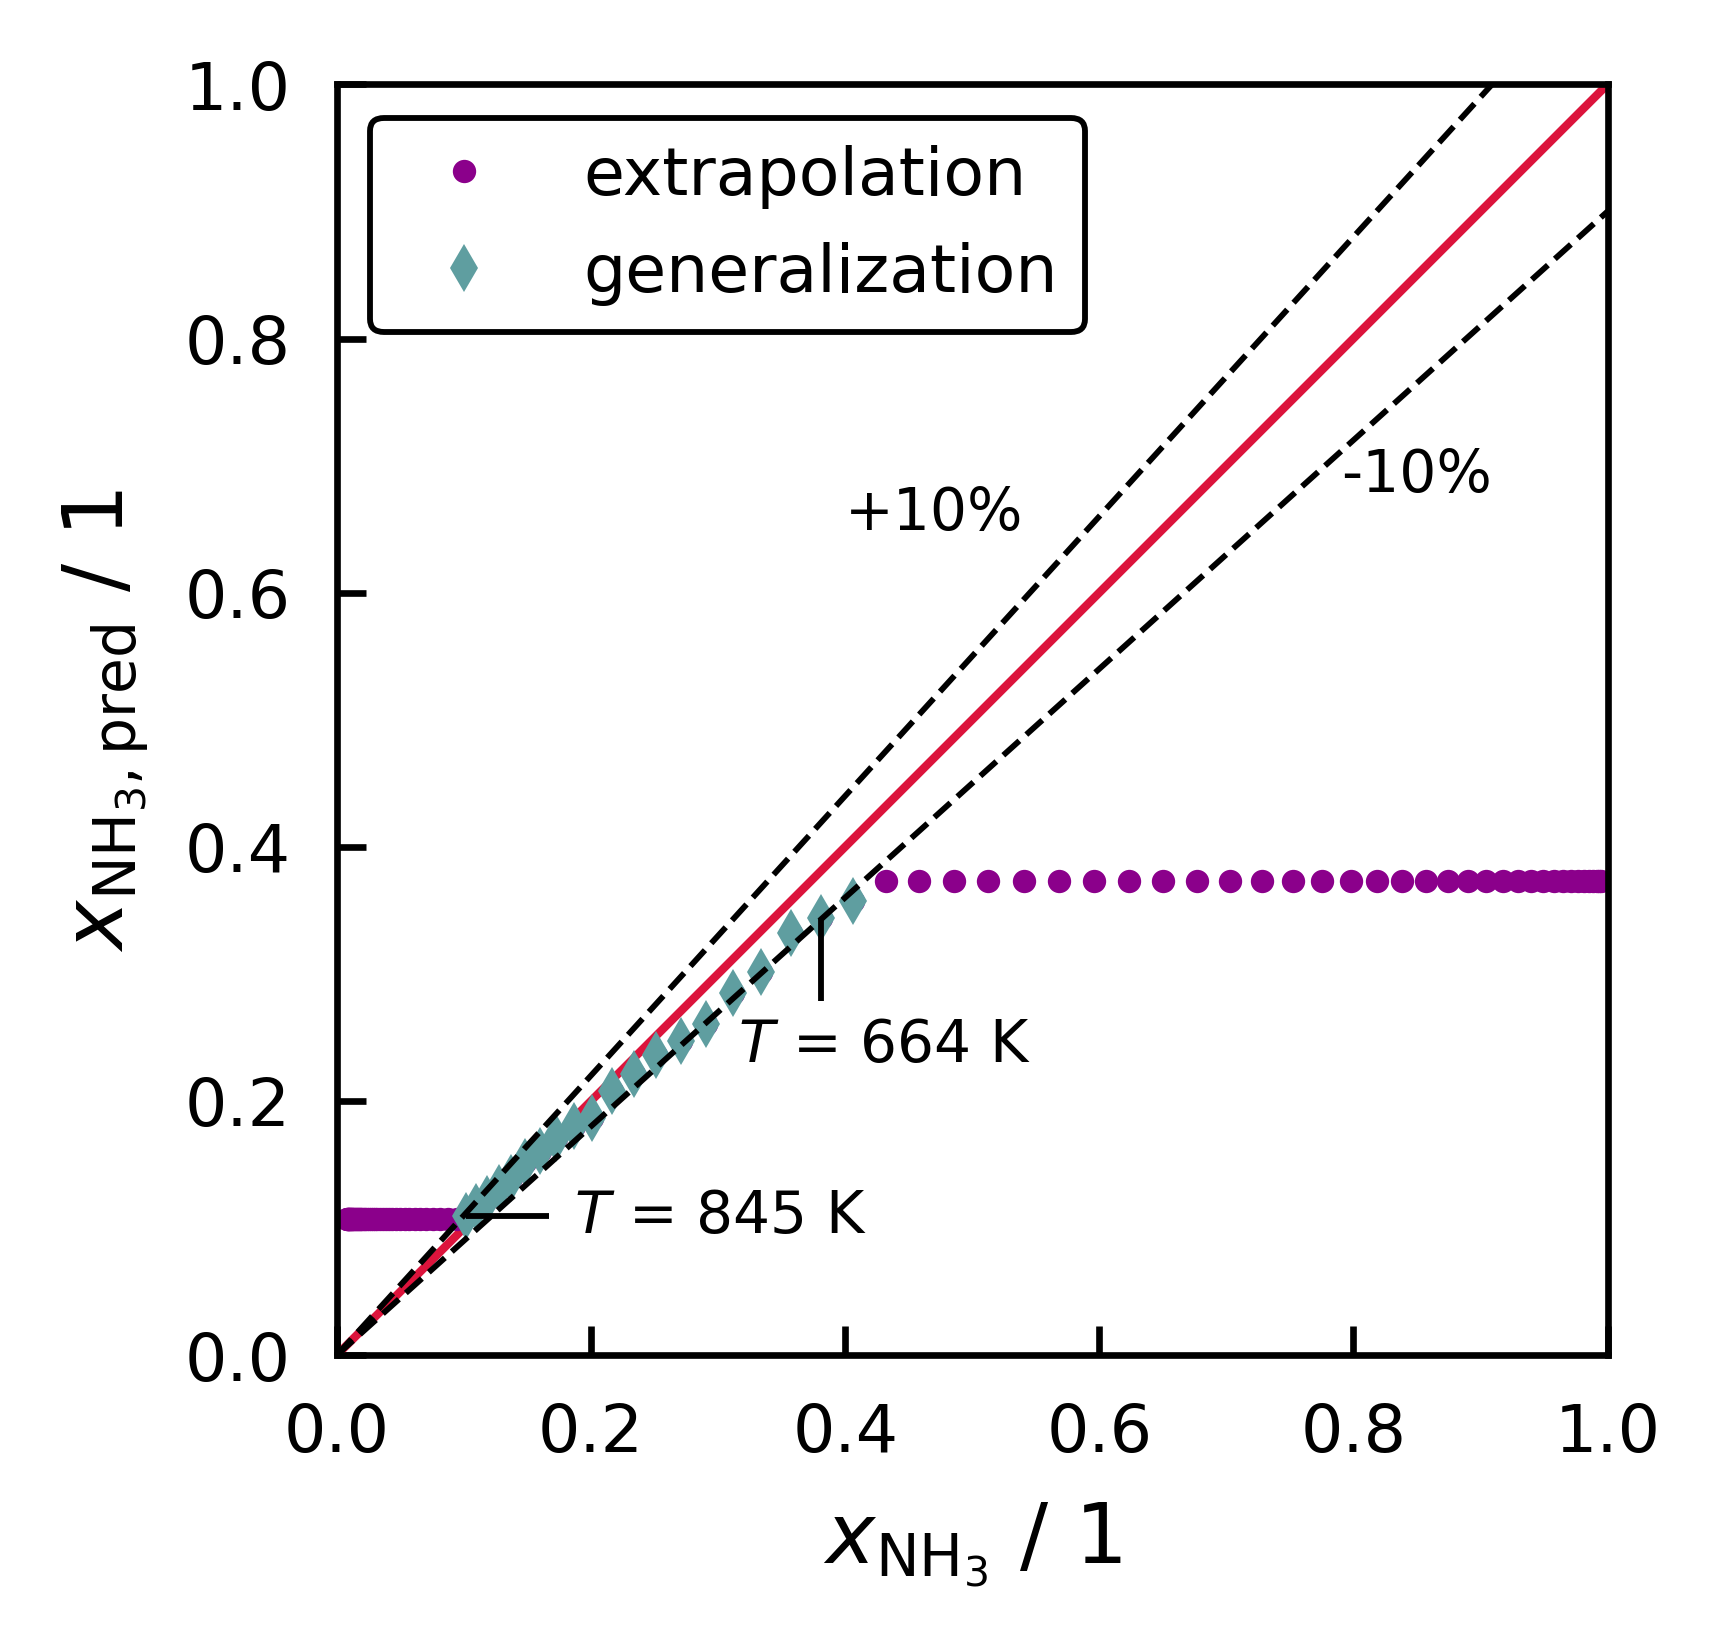

In [19]:
# Set the boundaries of X and Y values
bounds = (0,1)

fig,ax = plt.subplots(1, figsize =(7.5*cm,7.5*cm))

# # Reset the limits
# ax[0] = plt.gca()
ax.set_xlim(bounds)
ax.set_ylim(bounds)
# Ensure the aspect ratio is square
ax.set_aspect("equal", adjustable="box")

ax.plot([0, 1], [0, 1], "-", color='crimson', lw=1 ,transform=ax.transAxes)
ax.plot(x_NH3_real_3, x_NH3_pred_3, '.', label = 'extrapolation')
ax.plot([bounds[0],bounds[1]], [bounds[0] * 1.1, bounds[1] * 1.1], "k--", lw=0.7, zorder=100) # Error line
ax.plot([bounds[0],bounds[1]], [bounds[0] * 0.9, bounds[1] * 0.9], "k--", lw=0.7, zorder=100) # Error line
ax.text(0.4, 0.65, '+10%', fontsize=7)
ax.text(0.79, 0.68, '-10%', fontsize=7)
#ax.legend(['$\\mathregular{R^2}$ = ', r2(xi_real,xi_pred)], markerscale=0)

# Einfärben der Datenpunkte im Trainingsbereich
ax.plot(x_NH3_real_3[index_650:index_850], x_NH3_pred_3[index_650:index_850], 'd', markersize = 4, label='generalization')

# X_help = X_2.numpy()
index_down = np.where(x_NH3_pred_3 >= x_NH3_real_3 * 0.9)[0][0]
index_up = np.where(x_NH3_pred_3 <= x_NH3_real_3 * 1.1)[0][-1]
print(X_2[index_down,0])
print(X_2[index_up,0])
ax.plot(x_NH3_real_3[index_down], x_NH3_pred_3[index_down], marker = 3, markeredgewidth = 0.7, markersize=10,color='black')
ax.plot(x_NH3_real_3[index_up], x_NH3_pred_3[index_up], marker=1, markeredgewidth = 0.7, markersize=10,color='black')

#Text
ax.text(x_NH3_real_3[index_down]+0.05, x_NH3_pred_3[index_down] -0.1, ("$T$ = 664 K"), ha='center', va='center', fontsize=7, color='black', zorder=100)
ax.text(x_NH3_real_3[index_up]+0.2, x_NH3_pred_3[index_up], ("$T$ = 845 K"), ha='center', va='center', fontsize=7, color='black', zorder=100)

ax.set(xlabel = '$x\mathregular{_{NH_3}}$ / 1', ylabel = '$x\mathregular{_{NH_{3},pred}}$ / 1')
ax.tick_params(direction = 'in') #, length = 20, width = 3)
#ax.set_title('p = 200, x_0 = const')
ax.legend(loc='upper left')
#plt.legend()
#fig.suptitle("Parity Plot")
plt.tight_layout()
plt.show()

In [20]:
#fig.savefig(Path.cwd().parent / 'plots/ann/TKA_SRA_PA_006_parity_extra_2.png', bbox_inches = 'tight')

#### Laden und Preprocessing der Daten; T = const, x_0 = const

In [21]:
# Daten Extrapolation
eq_data_file_p_var_extra_haber = Path.cwd().parent / 'data' / 'eq_dataset_p_var_extra_haber.npz' #Import der GGW Daten
data_p_extra_haber = np.load(eq_data_file_p_var_extra_haber)

# Bei Speicherung wurden Daten als T, p, x_0 und x gespeichert
# Inputs T, p, x_0[H2,N2,NH3]
# Output x[NH3]
T = (data_p_extra_haber['T'])
p = (data_p_extra_haber['p'])
x_0 = (data_p_extra_haber['x_0'])
x = (data_p_extra_haber['x'])

X_1 = np.stack((np.full_like(p, T[0]), p, np.full_like(p, x_0[0]),np.full_like(p, x_0[1]),np.full_like(p, x_0[2])),1)
y_1 = x[:,0] # [H2, NH3], dritter Stoffmengenanteil ergibt sich den anderen
X_2 = np.stack((np.full_like(p, T[1]), p, np.full_like(p, x_0[0]),np.full_like(p, x_0[1]),np.full_like(p, x_0[2])),1)
y_2 = x[:,1] # [H2, NH3], dritter Stoffmengenanteil ergibt sich den anderen
X_3 = np.stack((np.full_like(p, T[2]), p, np.full_like(p, x_0[0]),np.full_like(p, x_0[1]),np.full_like(p, x_0[2])),1)
y_3 = x[:,2] # [H2, NH3], dritter Stoffmengenanteil ergibt sich den anderen
X_4 = np.stack((np.full_like(p, T[3]), p, np.full_like(p, x_0[0]),np.full_like(p, x_0[1]),np.full_like(p, x_0[2])),1)
y_4 = x[:,3] # [H2, NH3], dritter Stoffmengenanteil ergibt sich den anderen
# print(X)

#### Vorhersage der GGW Daten

In [22]:
dtest_1 = xgb.DMatrix(X_1, y_1)
dtest_2 = xgb.DMatrix(X_2, y_2)
dtest_3 = xgb.DMatrix(X_3, y_3)
dtest_4 = xgb.DMatrix(X_4, y_4)

pred_1 = xgb_model.predict(dtest_1)
pred_2 = xgb_model.predict(dtest_2)
pred_3 = xgb_model.predict(dtest_3)
pred_4 = xgb_model.predict(dtest_4)

#### Auswertung Verlauf x_NH3 über p, T =const, x_0 = const, Inter- und Extrapolation

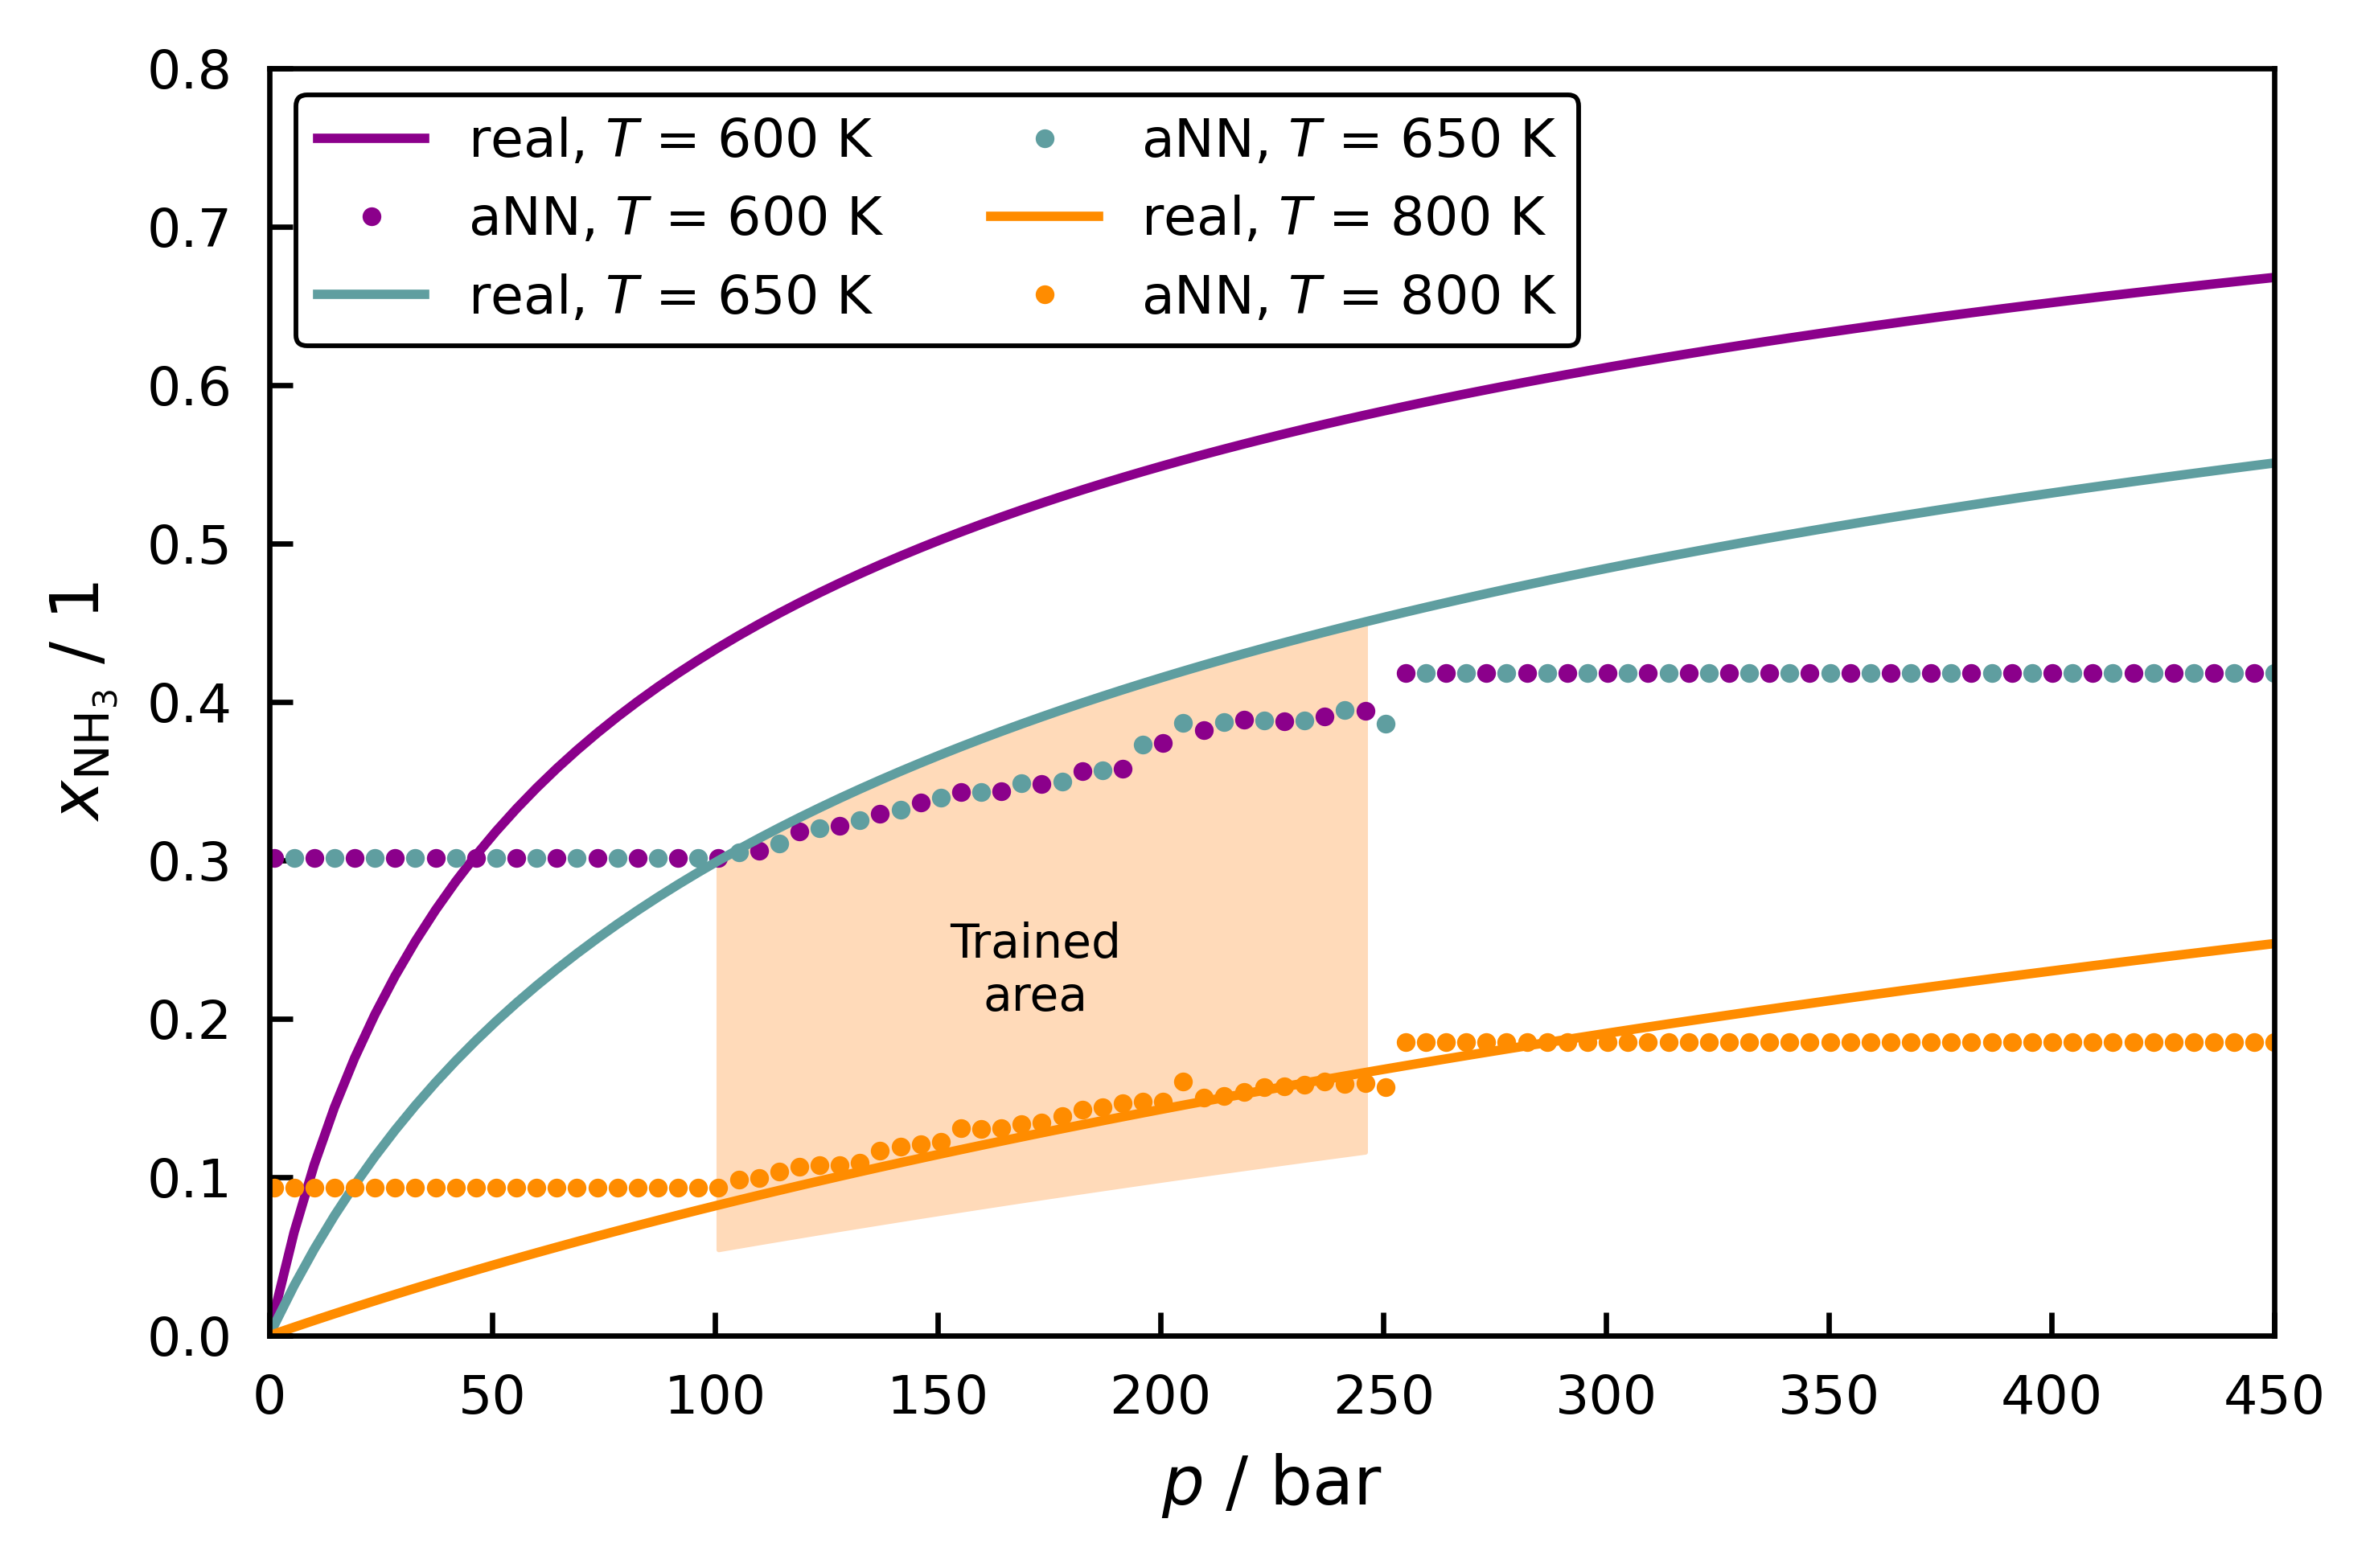

In [23]:
x_NH3_real_1 = y_1
x_NH3_pred_1 = pred_1[:,1]
x_NH3_real_2 = y_2
x_NH3_pred_2 = pred_2[:,1]
x_NH3_real_3 = y_3
x_NH3_pred_3 = pred_3[:,1]
x_NH3_real_4 = y_4
x_NH3_pred_4 = pred_4[:,1]

fig,ax = plt.subplots()

ax.plot(X_1[:,1], x_NH3_real_1, '-', color ='darkmagenta', label = 'real, $T$ = 600 K')
ax.plot(X_1[:,1][::2], x_NH3_pred_1[::2], '.', color ='darkmagenta', label = 'aNN, $T$ = 600 K')
ax.plot(X_2[:,1], x_NH3_real_2, '-', color ='cadetblue', label = 'real, $T$ = 650 K')
ax.plot(X_2[1:,1][::2], x_NH3_pred_2[1:][::2], '.', color ='cadetblue', label = 'aNN, $T$ = 650 K')
ax.plot(X_3[:,1], x_NH3_real_3, '-', color ='darkorange', label = 'real, $T$ = 800 K')
ax.plot(X_3[:,1], x_NH3_pred_3, '.', color ='darkorange', label = 'aNN, $T$ = 800 K')
# ax.plot(X_4[:,1], x_NH3_real_4, '-', color ='crimson', label = 'real, $T$ = 850 K')
# ax.plot(X_4[:,1], x_NH3_pred_4, '.', color ='crimson', label = 'aNN, $T$ = 850 K')

# ax.axvline(x=100, color='black', linestyle='dashed')
# ax.axvline(x=250, color='black', linestyle='dashed')

#fill in training arreas
X_help = X_2
index_100 = np.where(X_help[:,1] >= 100)[0][0]
index_250 = np.where(X_help[:,1] >= 250)[0][0]

# print(index_500)
# print(X_2[index_500:index_650,0])
ax.fill_between(X_2[index_100:index_250, 1],x_NH3_real_2[index_100:index_250], x_NH3_real_4[index_100:index_250], color = 'peachpuff', alpha = 1, zorder=1)#, label = 'Haber-Bosch')#,alpha = 0.6)

#Beschriftung Fläche
ax.text(172,  0.23, "Trained\narea", ha='center', va='center', fontsize=7, color='black', zorder=100)
#con = ConnectionPatch(xyA=(200, 0.25), coordsA=ax.transData,
#                      xyB=(200,0.4), coordsB=ax.transData, lw = 0.7, zorder=100)
#ax.add_artist(con)

ax.set(xlim=(0,450),ylim=(0,0.8))
ax.set(xlabel = '$p$ / bar', ylabel = '$x\mathregular{_{NH_3}}$ / 1')
ax.tick_params(direction = 'in') #, length = 20, width = 3)
#ax.set_title('T = const, x_0 = const')
ax.legend(ncols=2)
#ax.legend(['$\\mathregular{R^2}$ = ', r2(xi_real,xi_pred)], markerscale=0)

#plt.legend()
#fig.suptitle("Parity Plot")
plt.tight_layout()
plt.show()

In [24]:
#fig.savefig(Path.cwd().parent / 'plots/ann/TKA_SRA_PA_007_verlauf_extra_2.png', bbox_inches = 'tight')

#### Parity Plot

127.98989898989899
332.0808080808081


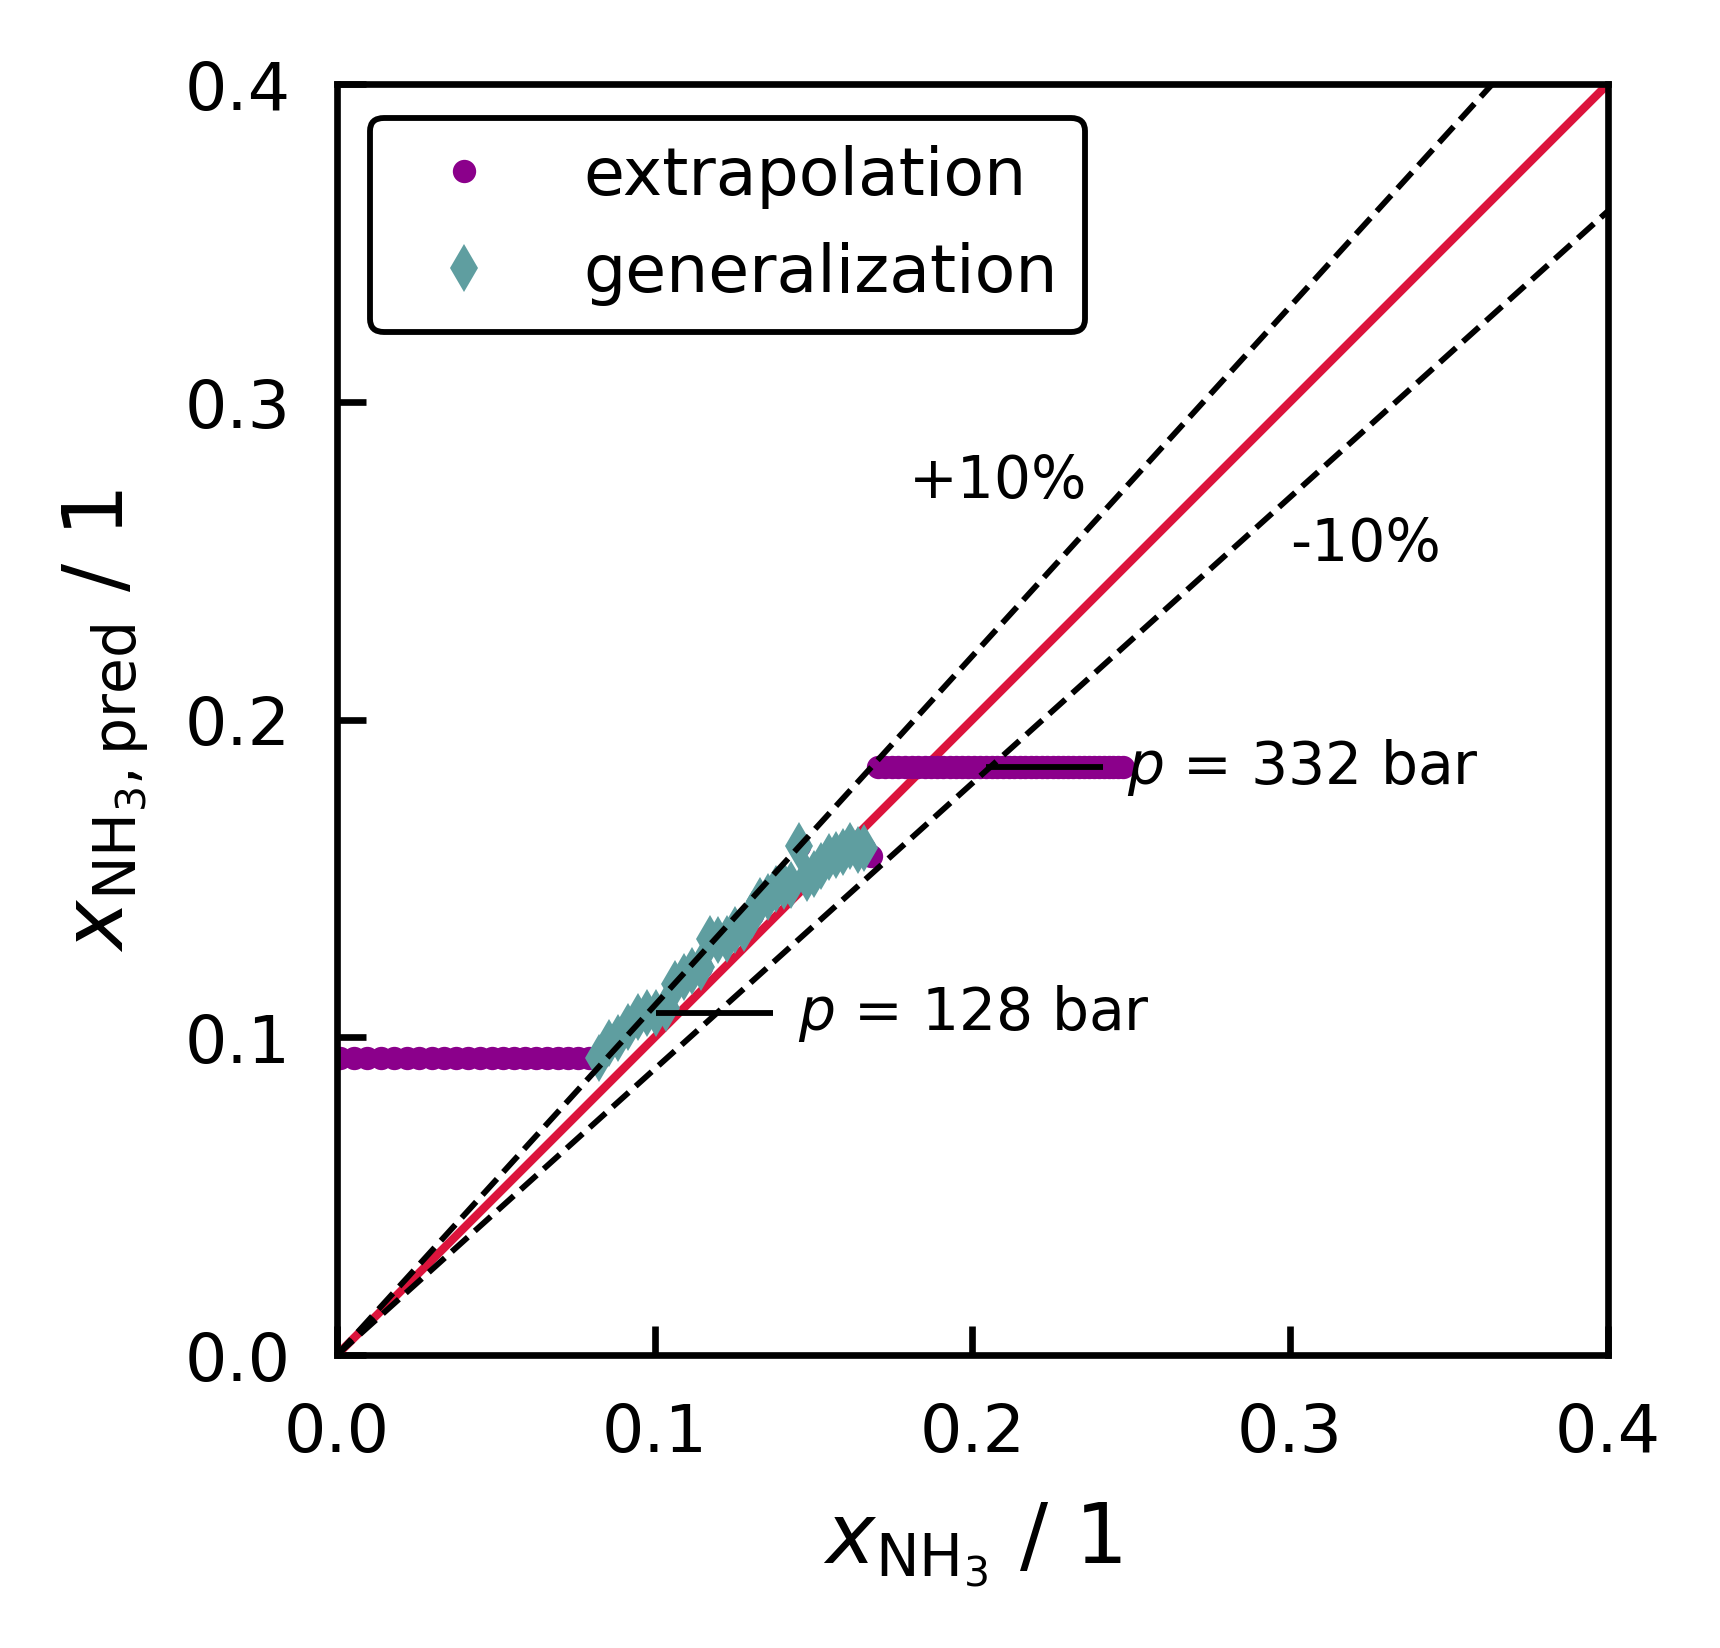

In [25]:
# Set the boundaries of X and Y values
bounds = (0,0.4)

fig,ax = plt.subplots(1, figsize =(7.5*cm,7.5*cm))

# # Reset the limits
# ax[0] = plt.gca()
ax.set_xlim(bounds)
ax.set_ylim(bounds)
# Ensure the aspect ratio is square
ax.set_aspect("equal", adjustable="box")

ax.plot([0, 1], [0, 1], "-", color='crimson', lw=1 ,transform=ax.transAxes)
ax.plot(x_NH3_real_3, x_NH3_pred_3, '.', label = 'extrapolation')
# ax.plot(x_NH3_real_2, x_NH3_pred_2, '.', color ='teal', label = '$T$ = 650 K')
# ax.plot(x_NH3_real_1, x_NH3_pred_1, '.', color ='orange', label = '$T$ = 600 K')
ax.plot([bounds[0],bounds[1]], [bounds[0] * 1.1, bounds[1] * 1.1], "k--", lw=0.7, zorder=100) # Error line
ax.plot([bounds[0],bounds[1]], [bounds[0] * 0.9, bounds[1] * 0.9], "k--", lw=0.7, zorder=100) # Error line
ax.text(0.18, 0.27, '+10%', fontsize=7)
ax.text(0.3, 0.25, '-10%', fontsize=7)

# Einfärben der Datenpunkte im Trainingsbereich
ax.plot(x_NH3_real_3[index_100:index_250], x_NH3_pred_3[index_100:index_250], 'd', markersize = 4, label='generalization')

# X_help = X_2.numpy()
index_up = np.where(x_NH3_pred_3 >= x_NH3_real_3 * 0.9)[0][-1]
index_down = np.where(x_NH3_pred_3 <= x_NH3_real_3 * 1.1)[0][0]
print(X_2[index_down,1])
print(X_2[index_up,1])
ax.plot(x_NH3_real_3[index_down], x_NH3_pred_3[index_down], marker = 1, markeredgewidth = 0.7, markersize=14,color='black')
ax.plot(x_NH3_real_3[index_up], x_NH3_pred_3[index_up], marker=1, markeredgewidth = 0.7, markersize=14,color='black')

#Text
ax.text(x_NH3_real_3[index_down]+0.1, x_NH3_pred_3[index_down] , ("$p$ = 128 bar"), ha='center', va='center', fontsize=7, color='black', zorder=100)
ax.text(x_NH3_real_3[index_up]+0.1, x_NH3_pred_3[index_up], ("$p$ = 332 bar"), ha='center', va='center', fontsize=7, color='black', zorder=100)


plt.yticks(np.arange(0,0.5,0.1))
ax.set(xlabel = '$x\mathregular{_{NH_3}}$ / 1', ylabel = '$x\mathregular{_{NH_{3},pred}}$ / 1')
ax.tick_params(direction = 'in') #, length = 20, width = 3)
#ax.set_title('T = const, x_0 = const')
ax.legend()
#ax.legend(['$\\mathregular{R^2}$ = ', r2(xi_real,xi_pred)], markerscale=0)

#plt.legend()
#fig.suptitle("Parity Plot")
plt.tight_layout()
plt.show()

In [26]:
#fig.savefig(Path.cwd().parent / 'plots/ann/TKA_SRA_PA_008_parity_extra_3.png', bbox_inches = 'tight')

### Ermittlung der Laufzeit zur Vorhersage von Datenpunkten

#### Laden und Preprocessing der 10 000 und 100 000 Datenpunkte

In [27]:
# Datei zehntausend Datenpunkte laden
eq_data_file_x_ztsd = Path.cwd().parent / 'data' / 'eq_dataset_x_10000.npz' #Import der GGW Daten
data_ztsd = np.load(eq_data_file_x_ztsd)

# Bei Speicherung wurden Daten als T, p, x_0 und x gespeichert
# Inputs T, p, x_0[H2,N2,NH3]
# Output x[H2, NH3]
T = (data_ztsd['T'])
p = (data_ztsd['p'])
x_0 = (data_ztsd['x_0'])

X_ztsd = np.stack((T, p ,x_0[:,0],x_0[:,1],x_0[:,2]),1)
X_norm_ztsd = (X - mean_in) / std_in

# Datei hunderdtausend Datenpunkte laden
eq_data_file_x_zwtsd = Path.cwd().parent / 'data' / 'eq_dataset_x_20000.npz' #Import der GGW Daten
data_zwtsd = np.load(eq_data_file_x_zwtsd)

T = (data_zwtsd['T'])
p = (data_zwtsd['p'])
x_0 = (data_zwtsd['x_0'])

X_zwtsd = np.stack((T, p ,x_0[:,0],x_0[:,1],x_0[:,2]),1)
X_norm_zwtsd = (X_zwtsd - mean_in) / std_in

# Datei hunderdtausend Datenpunkte laden
eq_data_file_x_htsd = Path.cwd().parent / 'data' / 'eq_dataset_x_hndtsd.npz' #Import der GGW Daten
data_htsd = np.load(eq_data_file_x_htsd)

T = (data_htsd['T'])
p = (data_htsd['p'])
x_0 = (data_htsd['x_0'])

X_htsd = np.stack((T, p ,x_0[:,0],x_0[:,1],x_0[:,2]),1)
X_norm_htsd = (X - mean_in) / std_in

NameError: name 'mean_in' is not defined

#### Bestimmung der Laufzeiten

In [ ]:
# net.eval()

# X_100 = X_1_norm # 100 Datenpaare
# X_1000 = X_norm # 1000 Datenpaare
# X_10000 = X_norm_ztsd # 10 000 Datenpaare
# X_20000 = X_norm_zwtsd # 20 000 Datenpaare
# X_htsd = X_norm_htsd # 100 000 Datenpaare


# pred_time_100 = timeit.timeit('net(X_100)', number = 10000, globals=globals()) / 10000
# pred_time_1000 = timeit.timeit('net(X_1000)', number = 10000, globals=globals()) / 10000
# pred_time_10000 = timeit.timeit('net(X_10000)', number = 1000, globals=globals()) / 1000
# pred_time_20000 = timeit.timeit('net(X_20000)', number = 1000, globals=globals()) / 1000
# pred_time_htsd = timeit.timeit('net(X_htsd)', number = 100, globals=globals()) / 100


# print('100:', pred_time_100, '1000:', pred_time_1000, '10 000:', pred_time_10000, '20 000:', pred_time_20000, '100 000:', pred_time_htsd)
#np.savez((Path.cwd().parent / 'data'/'ann_time.npz'), ann_time_100 = pred_time_100, ann_time_1000 = pred_time_1000, ann_time_10000 = pred_time_10000, ann_time_20000 = pred_time_20000, ann_time_htsd = pred_time_htsd)

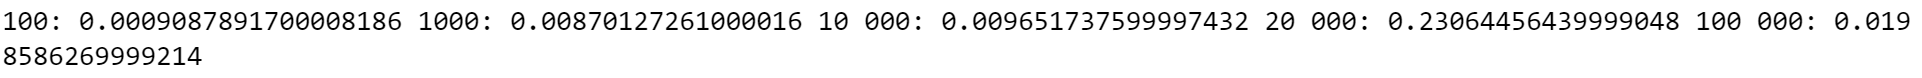